# Carbon Black

## Monthly

### ALL

Epoch 1/100
7/7 [==============================] - 3s 12ms/step - loss: 0.0798
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0306
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0157
Epoch 5/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0128
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0138
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0125
Epoch 8/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0123
Epoch 9/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0099
Epoch 10/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0099
Epoch 11/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 12/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0079
Epoch 13/100
7/7 [==============================] -

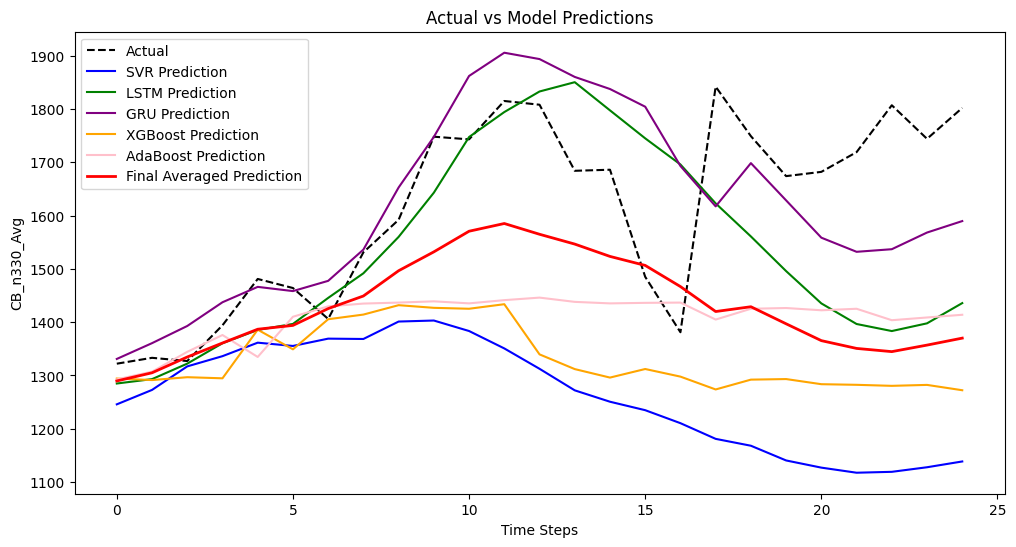

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('cb_dataset.csv')

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

# Drop rows with missing values
data.dropna(inplace=True)

# Convert 'Vol.' column to numeric if needed
data['Vol.'] = data['Vol.'].astype(str).str.replace(',', '').astype(float)

# Sort by date
data.sort_values('Date', inplace=True)

# Select features and target
features = ['Open', 'High', 'Low', 'Vol.', 'Price', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Normalize the features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])

data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Function to create sequences for time-series models
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(data_scaled.values, time_steps)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# SVR Model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
svr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
svr_predictions = svr_model.predict(X_test.reshape(X_test.shape[0], -1))

# LSTM Model
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)
lstm_predictions = lstm_model.predict(X_test).flatten()

#  GRU Model
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)
gru_predictions = gru_model.predict(X_test).flatten()

# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

#  AdaBoost Model
ada_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1)
ada_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
ada_predictions = ada_model.predict(X_test.reshape(X_test.shape[0], -1))

#  Final Prediction (Averaging All Models)
final_predictions = (svr_predictions + lstm_predictions + gru_predictions +
                     xgb_predictions + ada_predictions) / 5

# Reverse scale predictions
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
svr_rescaled = scaler_target.inverse_transform(svr_predictions.reshape(-1, 1))
lstm_rescaled = scaler_target.inverse_transform(lstm_predictions.reshape(-1, 1))
gru_rescaled = scaler_target.inverse_transform(gru_predictions.reshape(-1, 1))
xgb_rescaled = scaler_target.inverse_transform(xgb_predictions.reshape(-1, 1))
ada_rescaled = scaler_target.inverse_transform(ada_predictions.reshape(-1, 1))
final_rescaled = scaler_target.inverse_transform(final_predictions.reshape(-1, 1))

# Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test_rescaled, final_rescaled))
mse = mean_squared_error(y_test_rescaled, final_rescaled)
accuracy = 100 - np.mean(np.abs((y_test_rescaled - final_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual', color='black', linestyle='dashed')
plt.plot(svr_rescaled, label='SVR Prediction', color='blue')
plt.plot(lstm_rescaled, label='LSTM Prediction', color='green')
plt.plot(gru_rescaled, label='GRU Prediction', color='purple')
plt.plot(xgb_rescaled, label='XGBoost Prediction', color='orange')
plt.plot(ada_rescaled, label='AdaBoost Prediction', color='pink')
plt.plot(final_rescaled, label='Final Averaged Prediction', color='red', linewidth=2)
plt.title('Actual vs Model Predictions')
plt.xlabel('Time Steps')
plt.ylabel('CB_n330_Avg')
plt.legend()
plt.show()


### GRU + LSTM

Epoch 1/50
7/7 [==============================] - 2s 11ms/step - loss: 0.0660
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0347
Epoch 3/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0220
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0135
Epoch 5/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0130
Epoch 6/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0128
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0116
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0114
Epoch 9/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 10/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0098
Epoch 11/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 12/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0072
Epoch 13/50
7/7 [==============================] - 0s 10ms/step -

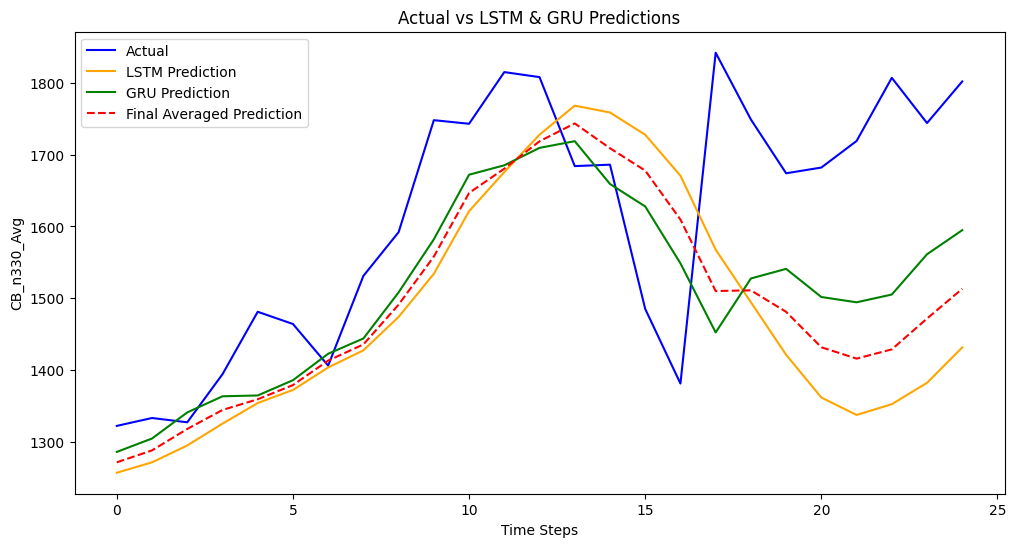

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('cb_dataset.csv') 

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

# Drop rows with missing values
data.dropna(inplace=True)

# Convert 'Vol.' column to numeric if needed
data['Vol.'] = data['Vol.'].astype(str).str.replace(',', '').astype(float)

# Sort by date
data.sort_values('Date', inplace=True)

# Select features and target
features = ['Open', 'High', 'Low', 'Vol.', 'Price', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Normalize the features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])

# Convert to DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Function to create sequences for time-series models
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])  # Input features
        y.append(data[i + time_steps, -1])    # Target
    return np.array(X), np.array(y)

time_steps = 12  # Past 12 steps for prediction
X, y = create_sequences(data_scaled.values, time_steps)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# **LSTM Model**
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)
lstm_predictions = lstm_model.predict(X_test).flatten()

# **GRU Model**
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)
gru_predictions = gru_model.predict(X_test).flatten()

# **Final Prediction (Averaging LSTM and GRU)**
final_predictions = (lstm_predictions + gru_predictions) / 2

# Reverse scale predictions
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_rescaled = scaler_target.inverse_transform(lstm_predictions.reshape(-1, 1))
gru_predictions_rescaled = scaler_target.inverse_transform(gru_predictions.reshape(-1, 1))
final_predictions_rescaled = scaler_target.inverse_transform(final_predictions.reshape(-1, 1))

# Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test_rescaled, final_predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, final_predictions_rescaled)
accuracy = 100 - np.mean(np.abs((y_test_rescaled - final_predictions_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(lstm_predictions_rescaled, label='LSTM Prediction', color='orange')
plt.plot(gru_predictions_rescaled, label='GRU Prediction', color='green')
plt.plot(final_predictions_rescaled, label='Final Averaged Prediction', color='red', linestyle='dashed')
plt.title('Actual vs LSTM & GRU Predictions')
plt.xlabel('Time Steps')
plt.ylabel('CB_n330_Avg')
plt.legend()
plt.show()


### Weight GRU + LSTM

Epoch 1/30
7/7 [==============================] - 2s 12ms/step - loss: 0.0727
Epoch 2/30
7/7 [==============================] - 0s 12ms/step - loss: 0.0141
Epoch 3/30
7/7 [==============================] - 0s 11ms/step - loss: 0.0093
Epoch 4/30
7/7 [==============================] - 0s 10ms/step - loss: 0.0082
Epoch 5/30
7/7 [==============================] - 0s 9ms/step - loss: 0.0082
Epoch 6/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 7/30
7/7 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 8/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 9/30
7/7 [==============================] - 0s 9ms/step - loss: 0.0063
Epoch 10/30
7/7 [==============================] - 0s 9ms/step - loss: 0.0055
Epoch 11/30
7/7 [==============================] - 0s 8ms/step - loss: 0.0052
Epoch 12/30
7/7 [==============================] - 0s 11ms/step - loss: 0.0044
Epoch 13/30
7/7 [==============================] - 0s 10ms/step - lo

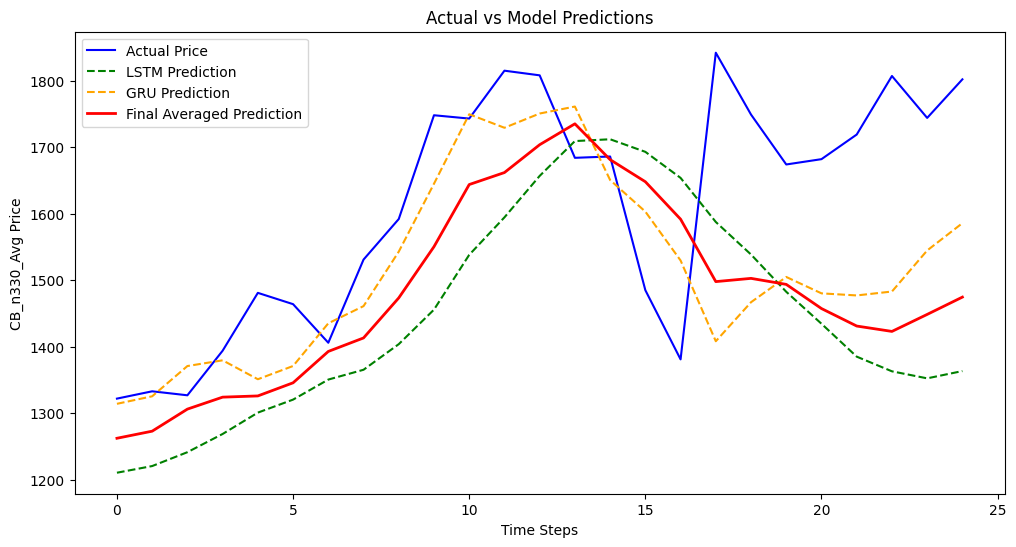

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# Load dataset
data = pd.read_csv('cb_dataset.csv')

# Convert 'Date' to datetime and sort
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data.dropna(inplace=True)
data.sort_values('Date', inplace=True)

# Convert 'Vol.' column to numeric if necessary
data['Vol.'] = data['Vol.'].astype(str).str.replace(',', '').astype(float)

# Select features and target
features = ['Open', 'High', 'Low', 'Vol.', 'Price', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Normalize the features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Function to create sequences for time-series models
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])  # Input features
        y.append(data[i + time_steps, -1])    # Target
    return np.array(X), np.array(y)

time_steps = 12  # Lookback period for predictions
X, y = create_sequences(data_scaled.values, time_steps)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Compute sample weights (higher for recent data)
years = data['Date'].dt.year[time_steps:]  # Align with sequence data
year_min, year_max = years.min(), years.max()
weights = np.exp((years - year_min) / (year_max - year_min))  # Exponential weighting
weights /= weights.max()  # Normalize

# LSTM Model
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, sample_weight=weights[:len(y_train)], epochs=30, batch_size=16, verbose=1)
lstm_predictions = lstm_model.predict(X_test).flatten()

# GRU Model
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, sample_weight=weights[:len(y_train)], epochs=50, batch_size=16, verbose=1)
gru_predictions = gru_model.predict(X_test).flatten()

# Final Prediction (Averaging Both Models)
final_predictions = (lstm_predictions + gru_predictions) / 2

# Reverse scale predictions
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
lstm_rescaled = scaler_target.inverse_transform(lstm_predictions.reshape(-1, 1))
gru_rescaled = scaler_target.inverse_transform(gru_predictions.reshape(-1, 1))
final_rescaled = scaler_target.inverse_transform(final_predictions.reshape(-1, 1))

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(lstm_rescaled, label='LSTM Prediction', color='green', linestyle='dashed')
plt.plot(gru_rescaled, label='GRU Prediction', color='orange', linestyle='dashed')
plt.plot(final_rescaled, label='Final Averaged Prediction', color='red', linewidth=2)
plt.title('Actual vs Model Predictions')
plt.xlabel('Time Steps')
plt.ylabel('CB_n330_Avg Price')
plt.legend()
plt.show()
